In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive')

In [ ]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#reviews = pd.read_csv("drive/My Drive/Application/text_summary/news_summary.csv")
reviews = pd.read_csv("drive/My Drive/cnn/cnn_summary_cleaned.csv")
print(reviews.shape)
df_5=reviews.head(5)

(92579, 2)


In [ ]:
df_10= reviews.head(10)
df_10.to_csv("drive/My Drive/cnn/cnn_10_stories.csv")

In [ ]:
# Check for any nulls values
reviews.isnull().sum()

text         0
headlines    0
dtype: int64

In [ ]:
# let's inspect some reviews
for i in range(5):
    print("Review: ",i+1)
    print(reviews.headlines[i])
    print('-'*80)
    print(reviews.text[i])
    print()

Review:  1
 syrian official obama climbed to the top of the tree doesn not know how to get down obama sends a letter to the heads of the house and senate obama to seek congressional approval on military action against syria aim is to determine whether cw were used not by whom says u.n. spokesman 
--------------------------------------------------------------------------------
it is official u.s. president barack obama wants lawmakers to weigh in on whether to use military force in syria. obama sent a letter to the heads of the house and senate on saturday night, hours after announcing that he believes military action against syrian targets is the right step to take over the alleged use of chemical weapons. the proposed legislation from obama asks congress to approve the use of military force to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction. it is a step that is set to turn an international crisis into a fierce

# Lets cleaned datasets

In [ ]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR",}
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}

In [ ]:
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = EMAIL_REGEX.sub(' ',text)
    text = CURRENCY_REGEX.sub(' ',text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text    

In [ ]:
cleaned_headlines = []
cleaned_text = []

for headlines in reviews['headlines']:
    cleaned_headlines.append(clean_text(headlines, remove_stopwords=False))
print("Headlines are complete.")

for text in reviews['text']:
    cleaned_text.append(clean_text(text))
print("Texts are complete.")

Headlines are complete.
Texts are complete.


In [ ]:
# let's inspect some clean reviews
for i in range(4):
    print("Review: ",i+1)
    print(cleaned_headlines[i])
    print('-'*80)
    print(cleaned_text[i])
    print()

Review:  1
syrian official obama climbed to the top of the tree doesn not know how to get down obama sends a letter to the heads of the house and senate obama to seek congressional approval on military action against syria aim is to determine whether cw were used not by whom says u n  spokesman
--------------------------------------------------------------------------------
official u president barack obama wants lawmakers weigh whether use military force syria obama sent letter heads house senate saturday night hours announcing believes military action syrian targets right step take alleged use chemical weapons proposed legislation obama asks congress approve use military force deter disrupt prevent degrade potential future uses chemical weapons weapons mass destruction step set turn international crisis fierce domestic political battle key questions looming debate u n weapons inspectors find syria happens congress votes syrian government react televised address white house rose garde

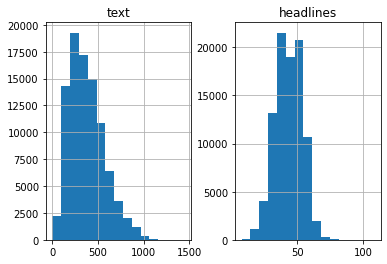

In [ ]:
# distribution of sequences
import matplotlib.pyplot as plt

text_word_count = []
headlines_word_count = []

for i in cleaned_text:
    text_word_count.append(len(i.split()))
for i in cleaned_headlines:
    headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text': text_word_count, 'headlines': headlines_word_count})
length_df.hist(bins=15)
plt.show()

In [ ]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=200):
        count += 1
print(count/len(cleaned_text))

0.19264628047397359


In [ ]:
count = 0
for i in cleaned_headlines:
    if(len(i.split())<=40):
        count += 1
print(count/len(cleaned_headlines))

0.395122003910174


In [ ]:
max_headlines_len=40
max_text_len=200

cleaned_text = np.array(cleaned_text)
cleaned_headlines = np.array(cleaned_headlines)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_headlines[i].split())<=max_headlines_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])

df=pd.DataFrame({'text':short_text,'headlines':short_headlines})
df['headlines'] = df['headlines'].apply(lambda x : 'sostok '+ x + ' eostok')

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['headlines']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
print(df.shape)

(11328, 2)


In [ ]:
df.to_csv('drive/My Drive/cnn/cnn_summary_short.csv',index=False)

In [ ]:
#df= pd.read_csv('drive/My Drive/cnn/cnn_summary_short.csv')
#from sklearn.model_selection import train_test_split
#x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['headlines']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

x_voc

% of rare words in vocabulary: 57.972024406410924
Total Coverage of rare words: 3.6926995205741555


24729

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_headlines_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_headlines_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)   

% of rare words in vocabulary: 75.70933419313236
Total Coverage of rare words: 10.001568144594547


(10195, 10195)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim=110

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 110)     2720190     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 200), ( 248800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
80/80 [==============================] - 145s 2s/step - loss: 6.0486 - val_loss: 5.0937
Epoch 2/50
80/80 [==============================] - 135s 2s/step - loss: 5.1397 - val_loss: 4.9424
Epoch 3/50
80/80 [==============================] - 136s 2s/step - loss: 4.9790 - val_loss: 4.8134
Epoch 4/50
80/80 [==============================] - 135s 2s/step - loss: 4.8363 - val_loss: 4.7141
Epoch 5/50
80/80 [==============================] - 136s 2s/step - loss: 4.7287 - val_loss: 4.6156
Epoch 6/50
80/80 [==============================] - 136s 2s/step - loss: 4.6085 - val_loss: 4.5235
Epoch 7/50
80/80 [==============================] - 136s 2s/step - loss: 4.5095 - val_loss: 4.4598
Epoch 8/50
80/80 [==============================] - 136s 2s/step - loss: 4.4137 - val_loss: 4.3905
Epoch 9/50
80/80 [==============================] - 136s 2s/step - loss: 4.3195 - val_loss: 4.3396
Epoch 10/50
80/80 [==============================] - 136s 2s/step - loss: 4.2514 - val_loss: 4.3252
Epoch 11/

In [ ]:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save('text_cnn_summary.h5')    
#model_file = drive.CreateFile({'title' : 'text_summary.h5'})
#model_file.SetContentFile('text_summary.h5')
#model_file.Upload()

# download to google drive
#drive.CreateFile({'id': model_file.get('id')})

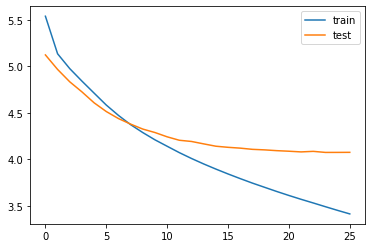

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
predictions = []
reference=[]

for i in range(0,50):
    print("Review:",seq2text(x_tr[i]))
    
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: man accused crimes humanity evaded international criminal court warrants seven years surrendered u embassy kigali rwanda officials said monday confirm morning ntaganda walked u embassy kigali specifically asked transferred icc hague currently consulting number governments including rwandan government order facilitate request u state department spokeswoman victoria nuland told reporters said think u authorities advance notice would surrender news ntaganda turning also reported twitter post rwandan minister foreign affairs louise icc first issued arrest warrant ntaganda different times congolese rebel leader general army democratic republic congo 2006 warrant alleged ntaganda forced children become soldiers drc second icc warrant issued july 2012 accused ntaganda murder rape attacks civilians slavery aliza kassim contributed report 
Original summary: turns himself in at the u s embassy in he asks to be transferred to the international criminal court in the is accused of forcing c

In [ ]:
!pip install sumeval

     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Created wheel for sumeval: filename=sumeval-0.2.2-cp37-none-any.whl size=54536 sha256=fbba13630cba217064536ea61de4e1df574fbe3ce36580631a18b3db48472fe4
  Stored in directory: /root/.cache/pip/wheels/7b/6f/57/19ceecab21445c88f3c565735fa1887b4cd18d340c972eb445
Successfully built sumeval


In [ ]:
from sumeval.metrics.rouge import RougeCalculator

In [ ]:
predictions = []
reference=[]

for i in range(0,50):
#    print("Review:",seq2text(x_tr[i]))
    origsum = seq2summary(y_tr[i])
    reference.append(origsum)
    predsum = decode_sequence(x_tr[i].reshape(1,max_text_len))
    predictions.append(predsum)
#    print("Original summary:",seq2summary(y_tr[i]))
#    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
#    print("\n")

In [ ]:
rouge = RougeCalculator(stopwords=True, lang="en")
Rouge_1 = []
Rouge_2 = []
Rouge_l = []

for i in range(len(predictions)):

    rouge_1 = rouge.rouge_n(
    summary=predictions[i],
    references=reference[i],
    n=1)
    Rouge_1.append(rouge_1)
 
 
 ## rogue_2

    rouge_2 = rouge.rouge_n(
    summary=predictions[i],
    references=reference[i],
    n=2)
    Rouge_2.append(rouge_2)
 ## rogue_l

    rouge_l = rouge.rouge_l(
    summary=predictions[i],
    references=reference[i])
    Rouge_l.append(rouge_l)

print("ROUGE-1: {}, ROUGE-2: {}, ROUGE-L: {}".format(np.round(sum(Rouge_1)/len(Rouge_1),3),
 np.round(sum(Rouge_2)/len(Rouge_2),3),
 np.round(sum(Rouge_l)/len(Rouge_l),3)
))

ROUGE-1: 0.055, ROUGE-2: 0.006, ROUGE-L: 0.05
